In [3]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from UsefulFunctions import *
import seaborn as sns
from config_path import MS_DATA_PATH
from dpks.quant_matrix import QuantMatrix
print(MS_DATA_PATH)

Base path: ..
../data/ms


In [4]:
long = pd.read_csv(f"{MS_DATA_PATH}/longitudinal_data.tsv", sep = "\t")
subtypes = pd.read_csv(f"{MS_DATA_PATH}/subtypes_data.tsv", sep = "\t")
design_matrix = pd.read_csv(f"{MS_DATA_PATH}/design_matrix_longitudinal.tsv", sep = "\t")
design_matrix['Sample'] = design_matrix['Sample'].str.replace('.osw','')
design_matrix['Subtype'].replace(1, '1', inplace=True)
design_matrix['Subtype'].replace(2, '2', inplace=True)

design_matrix_na = design_matrix[~design_matrix['Subtype'].isin(["1","2"])]
na_samples = design_matrix_na['Sample'].values
design_matrix_nona = design_matrix[design_matrix['Subtype'].isin(["1","2"])]
nona_samples = design_matrix_nona['Sample'].values
design_matrix.fillna('No Label', inplace=True)


/tmp/ipykernel_653/3005259677.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  design_matrix['Sample'] = design_matrix['Sample'].str.replace('.osw','')


([<matplotlib.patches.Wedge at 0x7fd3d960a580>,
 [Text(0.6975151512898278, 0.8505719333020159, '1'),
  Text(-1.094981195558016, -0.10495799814372354, '2'),
  Text(0.845990381827222, -0.8510583257661201, 'No label')],
 [Text(0.3804628097944515, 0.46394832725564494, '28.1%\n(74)'),
  Text(-0.5972624703043723, -0.057249817169303746, '46.8%\n(123)'),
  Text(0.49349438939921275, -0.4964506900302367, '25.1%\n(66)')])

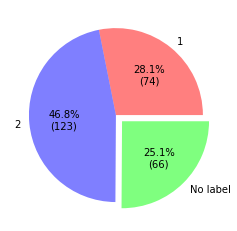

In [3]:
design_matrix.fillna('No label', inplace=True)
labels = design_matrix.groupby('Subtype').count()['Sample']
explode = [0, 0, 0.1]
def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return "{:.1f}%\n({:d})".format(pct, absolute)
plt.pie(x=labels, labels=labels.index, colors=[(1,0,0,0.5), (0,0,1,0.5), (0,1,0,0.5)], autopct=lambda pct: func(pct, labels), explode=explode)
#plt.savefig('../plots/general/LabelPie.jpg', annotate=True, dpi=300, bbox_inches='tight')

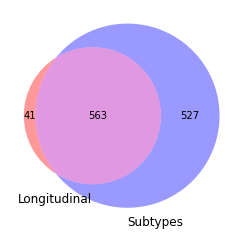

In [28]:
from matplotlib_venn import venn2

protein_long = set(long['Protein'].unique())
protein_sub = set(subtypes['Protein'].unique())
venn2([protein_long, protein_sub], ('Longitudinal', 'Subtypes'), ('red', 'blue'))
#plt.savefig('../plots/general/ProteinVenn.jpg', dpi=300, bbox_inches='tight')

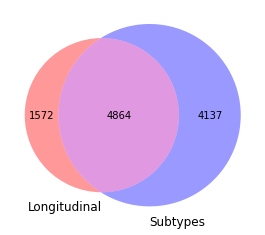

In [38]:
peptide_long = set(long['PeptideSequence'])
peptide_sub = set(subtypes['PeptideSequence'])
venn2([peptide_long, peptide_sub], ('Longitudinal', 'Subtypes'), ('red', 'blue'))
plt.savefig('../plots/general/PrecursorVenn.jpg', dpi=300, bbox_inches='tight')

In [5]:
# subtypes = subtypes[
#             (subtypes["PeptideQValue"] <= 0.01)
#             & (subtypes["ProteinQValue"] <= 0.01)]
                    
# long = long[
#             (long["PeptideQValue"] <= 0.01)
#             & (long["ProteinQValue"] <= 0.01)]

inner = long.merge(subtypes, how='inner', on = ['PeptideSequence', 'Charge', 'Protein', 'Decoy'])
inner['RetentionTime'] = inner['RetentionTime_y']
inner['PeptideQValue'] = inner['PeptideQValue_y']
inner['ProteinQValue'] = inner['ProteinQValue_y']
print(len(inner['Protein'].unique()))
print(len(inner.index))
[c for c in inner.columns if c.endswith('x')]
inner.drop(columns=['RetentionTime_x', 'RetentionTime_y'
                    ,'PeptideQValue_x', 'PeptideQValue_y', 
                    'ProteinQValue_x', 'ProteinQValue_y'], inplace=True)
inner.drop(columns=na_samples, inplace=True)


554
7336


/tmp/ipykernel_2615/4091191487.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  long_out['count'] = 1
/tmp/ipykernel_2615/4091191487.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  long_out['Data subset'] = 'Outer'
/tmp/ipykernel_2615/4091191487.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

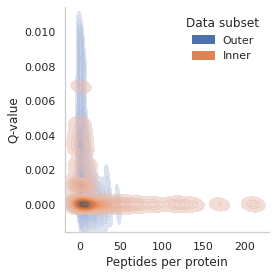

In [14]:
inner_proteins = inner['Protein'].values

long['in_inner'] = long['Protein'].apply(lambda x: True if x in inner_proteins else False)
subtypes['in_inner'] = subtypes['Protein'].apply(lambda x: True if x in inner_proteins else False)

long_out = long[long['in_inner'] == False]
subtypes_out = subtypes[subtypes['in_inner'] == False]

long_out['count'] = 1
long_out['Data subset'] = 'Outer'
subtypes_out['count'] = 1
subtypes_out['Data subset'] = 'Outer'
inner_temp = pd.DataFrame({'Protein':inner_proteins, 'PeptideQValue':inner['PeptideQValue'].values, 'ProteinQValue':inner['ProteinQValue'].values})
inner_temp['count'] = 1
inner_temp['Data subset'] = 'Inner'

long_out = long_out[['Protein', 'Data subset', 'count', 'ProteinQValue']]
subtypes_out = subtypes_out[['Protein', 'Data subset', 'count', 'ProteinQValue']]
inner_temp = inner_temp[['Protein', 'Data subset', 'count' ,'ProteinQValue']]


df = pd.concat([long_out, subtypes_out, inner_temp])
df = df.groupby(['Protein','Data subset'], as_index=False).agg({'count':'sum','ProteinQValue':'mean'})
df.sort_values('Data subset', inplace=True, ascending=False)
#df['ProteinQValue'] = df['ProteinQValue'].apply(lambda x: -np.log(x))
plt.figure(figsize=(4,4))
sns.set(rc={'legend.frameon':False })
sns.set_style("whitegrid",{'axes.grid' : False, "axes.facecolor":"none"})
sns.kdeplot(data=df, x='count', y='ProteinQValue',
            levels=100, hue='Data subset',thresh=0.001, alpha=.5 , fill=True, bw_adjust=.75)

plt.xlabel('Peptides per protein')
plt.ylabel('Q-value')
plt.tight_layout()
sns.despine()
plt.savefig('../plots/general/SubsetDensity.jpg', dpi=300, bbox_inches='tight')

In [206]:
inner.to_csv('../data/ms/inner.tsv', sep='\t', index=False)

design_matrix_nona['Group'] = design_matrix_nona['Subtype']
design_matrix_nona = design_matrix_nona[['Sample', 'Group']]
design_matrix_nona.to_csv('../data/ms/inner_design_matrix.tsv', sep='\t', index=False)

/tmp/ipykernel_2730/3889737988.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  design_matrix_nona['Group'] = design_matrix_nona['Subtype']


In [204]:


df = pd.read_csv(f'{MS_DATA_PATH}/inner.tsv', sep='\t')
design_matrix = pd.read_csv(f'{MS_DATA_PATH}/inner_design_matrix.tsv', sep='\t')

GroupOneCols = design_matrix[design_matrix['Group'] == 1]['Sample'].values
GroupTwoCols = design_matrix[design_matrix['Group'] == 2]['Sample'].values

print(len(GroupOneCols))
print(len(GroupTwoCols))

74
123


### Peptide distribution in samples

In [162]:
nr_unique_proteins = len(df['Protein'].unique())
print(f'# unique proteins: {nr_unique_proteins} ')

df['PeptideCount1'] = df[GroupOneCols].count(axis=1)
df['PeptideCount2'] = df[GroupTwoCols].count(axis=1)
df['PeptideCountSum'] = df['PeptideCount1']+df['PeptideCount2']
df['IntensitySum1'] = df[GroupOneCols].sum(axis=1)
df['IntensitySum2'] = df[GroupTwoCols].sum(axis=1)
df['IntensityMean1'] = df[GroupOneCols].mean(axis=1)
df['IntensityMean2'] = df[GroupTwoCols].mean(axis=1)
df['FC'] = df['IntensityMean1'] / df['IntensityMean2']
df['IntensitySum'] = df['IntensitySum1'] + df['IntensitySum2']

# unique proteins: 554 


### Protein level

## DPKS
---

In [3]:


quant_matrix = QuantMatrix(
    quantification_file=f"{MS_DATA_PATH}/inner.tsv",
    design_matrix_file=f"{MS_DATA_PATH}/inner_design_matrix.tsv"
)

qm = (
        quant_matrix
 # filter for q-values (removes rows with high q value (peptides), Q = 0.01) and removes decoys
        .normalize(method="mean", use_rt_sliding_window_filter=True) # best type of normalization is RT-sliding window
        .quantify(method="maxlfq") # play around with minimum_subgroups (default is set 1)
    )
#qm.to_df().to_csv('../data/ms/QuantMatrix.csv', index=False)
compare_df = qm.compare_groups(
        method='linregress',
        group_a=1,
        group_b=2,
        min_samples_per_group = 2, 
        level='protein',
    ).to_df()
compare_df

/home/erikh/master-thesis/my-venv/lib/python3.9/site-packages/dpks/normalization.py:116: RuntimeWarning: Mean of empty slice
  sample_means = np.nanmean(X, axis=0)


,Protein,Group1Mean,Group2Mean,Log2FoldChange1-2,PValues1-2,Group1RepCounts,Group2RepCounts,CorrectedPValue,TM_P1911_190,TM_P1911_191,...,TM_M2012_190,TM_M2012_191,TM_M2012_192,TM_M2012_196,TM_M2012_197,TM_M2012_198,TM_M2012_199,TM_M2012_200,TM_M2012_202,TM_M2012_203
0,P08603,22.955011,22.969308,-0.014297,0.754146,74,123,0.456914,22.381866,22.773908,...,23.416677,23.498007,23.459972,23.403313,23.454894,23.602666,23.682634,23.665858,24.015710,23.655648
1,P02671,24.843891,24.913566,-0.069675,0.361723,74,123,0.265325,25.349974,25.431340,...,24.984516,25.023149,24.971465,23.369445,24.604836,24.623221,24.787905,25.095571,25.103341,24.914344
2,P01042,22.693238,22.774973,-0.081735,0.150391,74,123,0.132915,22.061788,21.872170,...,22.953879,23.089170,23.018547,23.280626,23.503529,23.471356,23.471414,23.193750,24.101306,23.486766
3,P00450,23.129967,23.258546,-0.128578,0.043110,74,123,0.047552,22.647246,23.193086,...,23.788756,23.932623,23.904721,23.273831,23.462794,23.783564,23.968122,23.956618,23.989086,23.834912
4,P05156,21.371075,21.503436,-0.132362,0.108687,74,123,0.102986,21.301448,21.435684,...,21.850530,21.883567,21.936084,21.778412,22.051000,22.187546,21.965964,21.820840,22.373783,22.076671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
549,P07333,19.681788,19.994877,-0.313089,0.262549,12,54,0.207313,NaN,NaN,...,NaN,NaN,NaN,19.498665,NaN,NaN,NaN,NaN,NaN,NaN
550,Q06323,20.005343,18.487132,1.518211,0.104189,2,5,0.099704,NaN,NaN,...,NaN,NaN,NaN,18.418491,19.347011,NaN,NaN,19.331198,NaN,17.185418
551,P16035,18.870689,19.012296,-0.141607,0.662846,14,30,0.421389,NaN,18.396452,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
552,O95633,NaN,NaN,NaN,NaN,0,3,NaN,NaN,NaN,...,NaN,NaN,NaN,18.976126,NaN,NaN,NaN,NaN,NaN,NaN


/tmp/ipykernel_2730/1900047276.py:17: RuntimeWarning: divide by zero encountered in log10
  df_new['logI'] = [np.log10(x) for x in df_new['IntensitySum']]


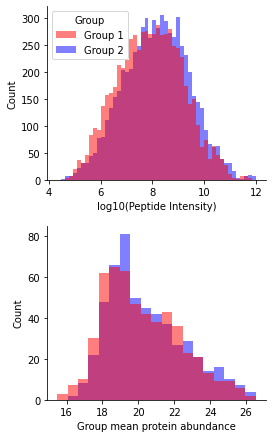

In [197]:
prot_df1 = compare_df[['Protein','Group1Mean']]
prot_df2 = compare_df[['Protein', 'Group2Mean']]
prot_df1 = prot_df1.rename(columns={'Group1Mean':'GroupMean'})
prot_df2 = prot_df2.rename(columns={'Group2Mean':'GroupMean'})
prot_df1['Group'] = 'Group 1'
prot_df2['Group'] = 'Group 2'

df1 = df[['PeptideSequence','IntensitySum1']]
df2 = df[['PeptideSequence', 'IntensitySum2']]
df1 = df1.rename(columns={'IntensitySum1':'IntensitySum'})
df2 = df2.rename(columns={'IntensitySum2':'IntensitySum'})
df1['Group'] = 'Group 1'
df2['Group'] = 'Group 2'

df_new = pd.concat([df1,df2])
df_new.reset_index(inplace=True)
df_new['logI'] = [np.log10(x) for x in df_new['IntensitySum']]
fig, ax = plt.subplots(2,1,figsize = (4,6), gridspec_kw={'height_ratios': [1, 1]})

sns.histplot(data=df_new, kde=False, x= 'logI', hue='Group', edgecolor=None, palette=['red','blue'], alpha=0.5, ax=ax[0])
ax[0].set_xlabel('log10(Peptide Intensity)')
sns.despine()
plt.tight_layout()

prot_df_new = pd.concat([prot_df1,prot_df2])
prot_df_new.reset_index(inplace=True)
sns.histplot(data=prot_df_new, kde=False, x= 'GroupMean', hue='Group', edgecolor=None, legend=False, palette=['red','blue'], alpha=0.5, ax=ax[1])
ax[1].set_xlabel('Group mean protein abundance')

plt.savefig('../plots/general/PepProtHist.jpg', dpi=300, bbox_inches='tight')

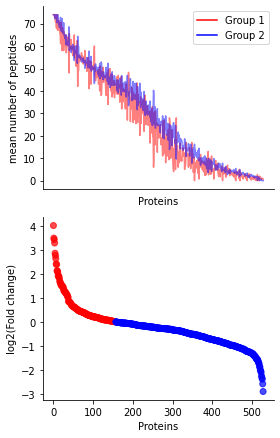

In [198]:
compare_df = compare_df.sort_values('Log2FoldChange1-2', ascending=False)
protein_peptide_count = df.groupby('Protein', as_index=False).mean()[['Protein','PeptideCount1','PeptideCount2','PeptideCountSum']]
compare_df_no_NaN = compare_df.dropna(subset=['Log2FoldChange1-2'])
#print(compare_df_no_NaN[:5].Protein, compare_df_no_NaN[:5]['Log2FoldChange1-2'])
#print(compare_df_no_NaN[len(compare_df_no_NaN.index)-5:len(compare_df_no_NaN.index)].Protein, 
     # compare_df_no_NaN[len(compare_df_no_NaN.index)-5:len(compare_df_no_NaN.index)]['Log2FoldChange1-2'])
def pltcolor(vals):
    cols=[]
    for y in vals:
        if y > 0:
            cols.append('red')
        else:
            cols.append('blue')
    return cols
colors = pltcolor(compare_df['Log2FoldChange1-2'].values)



groupratio = len(GroupOneCols)/len(GroupTwoCols)
protein_peptide_count = protein_peptide_count.sort_values('PeptideCountSum',ascending=False)
df1 = protein_peptide_count[['Protein','PeptideCount1']]
df2 = protein_peptide_count[['Protein', 'PeptideCount2']]
df1 = df1.rename(columns={'PeptideCount1':'PeptideCount'})
df2 = df2.rename(columns={'PeptideCount2':'PeptideCount'})
df1['Group'] = 'Group 1'
df2['Group'] = 'Group 2'
df2['PeptideCount'] = df2['PeptideCount'] * groupratio
df1['i'] = range(len(df1.index))
df2['i'] = range(len(df2.index))
df_new = pd.concat([df1,df2])
df_new.reset_index(inplace=True)



fig, ax = plt.subplots(2,1,figsize = (4,6), gridspec_kw={'height_ratios': [1, 1]})


sns.lineplot(data=df_new, x = 'Protein', y = 'PeptideCount', hue='Group', palette=['red','blue'], alpha=0.5, ax=ax[0])

ax[0].set_xticks([])
#plt.xscale('log')
ax[0].set_xlabel('Proteins')
ax[0].set_ylabel('mean number of peptides')
ax[0].legend()
sns.despine(top=True, right=True, left=False, bottom=False)


g = ax[1].scatter(x=range(len(compare_df.index)),y=compare_df['Log2FoldChange1-2'], alpha=0.7,color=colors)
sns.despine()
ax[1].set_ylabel('log2(Fold change)')
plt.tight_layout()
ax[1].set_xlabel('Proteins')
plt.savefig('../plots/general/PeptideDistFC.jpg', bbox_inches='tight', dpi=300)


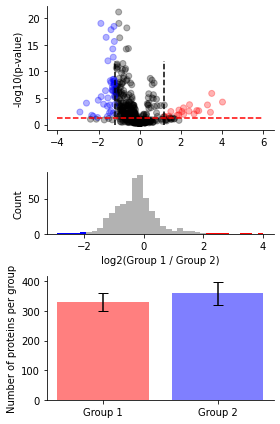

In [199]:
compare_df['logPValue'] = -1.0 * np.log10(compare_df['CorrectedPValue'])
compare_df['color'] = compare_df.apply(lambda x: color_if_significant(x), axis=1)

fig, ax = plt.subplots(3,1,sharex=False, figsize = (4,6), gridspec_kw={'height_ratios': [2, 1, 2]})

group1_proteins = []
for col in GroupOneCols:
    group1_proteins.append(compare_df[col].count())
group1_mean =  np.mean(group1_proteins)
group1_sd = np.std(group1_proteins)
group2_proteins = []
for col in GroupTwoCols:
    group2_proteins.append(compare_df[col].count())
group2_mean = np.mean(group2_proteins)
group2_sd = np.std(group2_proteins)


ax[0].scatter(x=compare_df['Log2FoldChange1-2'].values , y=compare_df['logPValue'].values, color=compare_df['color'].values, alpha=0.3)

ax[0].vlines(1.2, ymin=0, ymax=12, color='k', linestyle='dashed')
ax[0].vlines(-1.2, ymin=0, ymax=12,color='k', linestyle='dashed')
ax[0].hlines(1.31, xmin=-4, xmax=6, color='red', linestyle='dashed')
ax[0].set_ylabel('-log10(p-value)')

g = sns.histplot(compare_df['Log2FoldChange1-2'].values, color='black',alpha=0.3, linewidth=0, ax = ax[1])
for p in range(len(g.patches)):
    x,_ = g.patches[p].xy
    if x < -2:
        g.patches[p].set_facecolor('blue')
    elif x > 2:
        g.patches[p].set_facecolor('red')

ax[1].set_ylabel('Count')
ax[1].set_xlabel('log2(Group 1 / Group 2)')

ax[2].bar(x = ['Group 1', 'Group 2'], height = [group1_mean,group2_mean], 
        yerr=[group1_sd, group2_sd], 
        capsize=5, 
        color=['red', 'blue'], 
        alpha=0.5,)
ax[2].set_ylabel('Number of proteins per group')

plt.tight_layout()
sns.despine(ax=ax[0])
sns.despine(ax=ax[1])
sns.despine(ax=ax[2])

plt.savefig('../plots/general/ProteinVolcanoHist.jpg', bbox_inches='tight', dpi=300)

In [195]:
quant_matrix = QuantMatrix(
    quantification_file=f"{MS_DATA_PATH}/inner.tsv",
    design_matrix_file=f"{MS_DATA_PATH}/inner_design_matrix.tsv"
)

precursor_compare_df = (quant_matrix.normalize(method="mean", use_rt_sliding_window=True)).compare_groups(
        method='linregress',
        group_a=1,
        group_b=2,
        min_samples_per_group = 2, 
        level='precursor',
    ).to_df()

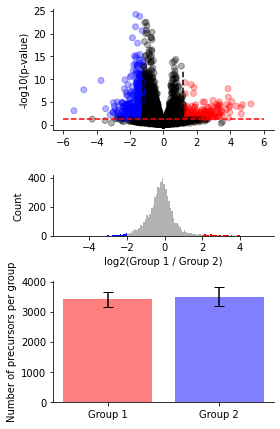

In [200]:
precursor_compare_df['logPValue'] = -1.0 * np.log10(precursor_compare_df['PValues1-2'])
precursor_compare_df['color'] = precursor_compare_df.apply(lambda x: color_if_significant(x), axis=1)

group1_precursor = []
for col in GroupOneCols:
    group1_precursor.append(precursor_compare_df[col].count())
group1_mean =  np.mean(group1_precursor)
group1_sd = np.std(group1_precursor)
group2_precursor = []
for col in GroupTwoCols:
    group2_precursor.append(precursor_compare_df[col].count())
group2_mean = np.mean(group2_precursor)
group2_sd = np.std(group2_precursor)

fig, ax = plt.subplots(3,1, figsize = (4,6), gridspec_kw={'height_ratios': [2, 1, 2]})
ax[0].scatter(x=precursor_compare_df['Log2FoldChange1-2'].values , y=precursor_compare_df['logPValue'].values, color=precursor_compare_df['color'].values, alpha=0.3)

ax[0].vlines(1.2, ymin=0, ymax=12, color='k', linestyle='dashed')
ax[0].vlines(-1.2, ymin=0, ymax=12,color='k', linestyle='dashed')
ax[0].hlines(1.31, xmin=-6, xmax=6, color='red', linestyle='dashed')
ax[0].set_ylabel('-log10(p-value)')

g = sns.histplot(precursor_compare_df['Log2FoldChange1-2'].values, color='black',alpha=0.3, linewidth=0, ax = ax[1])
for p in range(len(g.patches)):
    x,_ = g.patches[p].xy
    if x < -2:
        g.patches[p].set_facecolor('blue')
    elif x > 2:
        g.patches[p].set_facecolor('red')

ax[1].set_ylabel('Count')

ax[2].bar(x = ['Group 1', 'Group 2'], height = [group1_mean,group2_mean], 
        yerr=[group1_sd, group2_sd], 
        capsize=5, 
        color=['red', 'blue'], 
        alpha=0.5,)
ax[2].set_ylabel('Number of precursors per group')
ax[1].set_xlabel('log2(Group 1 / Group 2)')
plt.tight_layout()
sns.despine(ax=ax[0])
sns.despine(ax=ax[1])
sns.despine(ax=ax[2])
plt.savefig('../plots/general/PrecursorVolcanoHist.jpg', bbox_inches='tight', dpi=300)